# Import

In [1]:
import os
import lightgbm as lgb
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm.auto import tqdm
from scipy.optimize import curve_fit
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from pathlib import Path

warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [2]:
RANDOM_SEED = 42

BASE_DIR = Path("/kaggle/input/mallorn-astronomical-classification-challenge")
USECOLS = ["object_id", "Time (MJD)", "Flux", "Flux_err", "Filter"]
BANDS = ["u","g","r","i","z","y"]
BANDS_FIT = ["g", "r", "i"]
WIN_LEFT  = 200.0
WIN_RIGHT = 400.0
MIN_PTS_FIT = 10
MAXFEV = 8000
SEED = 42

CACHE_TRAIN = "train_bazin.parquet"
CACHE_TEST  = "test_bazin.parquet"

EXTINCTION_COEFFS = {'u': 4.81, 'g': 3.64, 'r': 2.70, 'i': 2.06, 'z': 1.58, 'y': 1.31}

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# EDA

In [3]:
SPLIT_DIRS = sorted([p for p in BASE_DIR.glob("split_*") if p.is_dir()])
if not SPLIT_DIRS:
    raise FileNotFoundError("Không tìm thấy thư mục split_* trong dataset.")
print("Splits:", [p.name for p in SPLIT_DIRS], " (n=", len(SPLIT_DIRS), ")")

Splits: ['split_01', 'split_02', 'split_03', 'split_04', 'split_05', 'split_06', 'split_07', 'split_08', 'split_09', 'split_10', 'split_11', 'split_12', 'split_13', 'split_14', 'split_15', 'split_16', 'split_17', 'split_18', 'split_19', 'split_20']  (n= 20 )


In [4]:
train_log = pd.read_csv(BASE_DIR / "train_log.csv")
test_log  = pd.read_csv(BASE_DIR / "test_log.csv")
sample_sub = pd.read_csv(BASE_DIR / "sample_submission.csv")

print("train_log:", train_log.shape)
print("test_log :", test_log.shape)
print("sample_sub:", sample_sub.shape)

display(train_log.head())
display(test_log.head())
display(sample_sub.head())

vc = train_log["target"].value_counts(dropna=False).sort_index()
print("\nTarget counts:\n", vc)
print("Positive rate:", (train_log["target"]==1).mean())

train_log: (3043, 8)
test_log : (7135, 7)
sample_sub: (7135, 2)


,object_id,Z,Z_err,EBV,SpecType,English Translation,split,target
0,Dornhoth_fervain_onodrim,3.0490,NaN,0.110,AGN,Trawn Folk (Dwarfs) + northern + Ents (people),split_01,0
1,Dornhoth_galadh_ylf,0.4324,NaN,0.058,SN II,Trawn Folk (Dwarfs) + tree + drinking vessel,split_01,0
2,Elrim_melethril_thul,0.4673,NaN,0.577,AGN,Elves + lover (fem.) + breath,split_01,0
3,Ithil_tobas_rodwen,0.6946,NaN,0.012,AGN,moon + roof + noble maiden,split_01,0
4,Mirion_adar_Druadan,0.4161,NaN,0.058,AGN,"jewel, Silmaril + father + Wild Man",split_01,0


,object_id,Z,Z_err,EBV,SpecType,English Translation,split
0,Eluwaith_Mithrim_nothrim,0.5393,0.03013,0.610,NaN,Sindar + Sindar + family,split_01
1,Eru_heledir_archam,0.7282,0.03508,0.058,NaN,God + kingfisher (bird) + throne,split_01
2,Gonhir_anann_fuin,0.6026,0.03185,0.070,NaN,"Master of Stone, Dwarf + long, for a long tim...",split_01
3,Gwathuirim_haradrim_tegilbor,0.5298,0.03013,0.014,NaN,Shadowy People (of Dunland) + People of the S...,split_01
4,achas_minai_maen,0.1654,0.02304,0.027,NaN,"achas + distinct, unique, single + clever, sk...",split_01


,object_id,prediction
0,Eluwaith_Mithrim_nothrim,0
1,Eru_heledir_archam,0
2,Gonhir_anann_fuin,0
3,Gwathuirim_haradrim_tegilbor,0
4,achas_minai_maen,0



Target counts:
 target
0    2895
1     148
Name: count, dtype: int64
Positive rate: 0.04863621426224121


In [5]:
def read_lightcurves(split_dirs, kind: str) -> pd.DataFrame:
    assert kind in ("train", "test")
    frames = []
    for sp in tqdm(split_dirs, desc=f"Reading {kind} lightcurves"):
        fp = sp / f"{kind}_full_lightcurves.csv"
        df = pd.read_csv(fp, usecols=USECOLS)
        frames.append(df)
    df = pd.concat(frames, ignore_index=True)

    df = df.rename(columns={
        "Time (MJD)": "mjd",
        "Flux": "flux",
        "Flux_err": "flux_err",
        "Filter": "band"
    })

    df["band"] = df["band"].astype("category")
    df["mjd"] = df["mjd"].astype("float32")
    df["flux"] = df["flux"].astype("float32")
    df["flux_err"] = df["flux_err"].astype("float32")

    before = len(df)
    df = df.dropna(subset=["flux", "flux_err", "mjd", "band", "object_id"])
    after = len(df)
    print(f"{kind}: dropped {before-after} rows with NaNs")

    df.loc[df["flux_err"] <= 0, "flux_err"] = np.nan
    df["snr"] = (df["flux"] / df["flux_err"]).astype("float32")
    return df

train_lc = read_lightcurves(SPLIT_DIRS, "train")
test_lc  = read_lightcurves(SPLIT_DIRS, "test")

print("train_lc:", train_lc.shape, "unique objects:", train_lc["object_id"].nunique())
print("test_lc :", test_lc.shape,  "unique objects:", test_lc["object_id"].nunique())

train_lc.head()

Reading train lightcurves:   0%|          | 0/20 [00:00<?, ?it/s]

train: dropped 891 rows with NaNs


Reading test lightcurves:   0%|          | 0/20 [00:00<?, ?it/s]

test: dropped 2022 rows with NaNs
train_lc: (478493, 6) unique objects: 3043
test_lc : (1143103, 6) unique objects: 7135


,object_id,mjd,flux,flux_err,band,snr
0,Dornhoth_fervain_onodrim,63314.464844,-1.630159,0.365777,z,-4.456698
1,Dornhoth_fervain_onodrim,63780.968750,10.499390,0.253867,r,41.357761
2,Dornhoth_fervain_onodrim,63789.769531,5.866250,1.559241,y,3.762247
3,Dornhoth_fervain_onodrim,63794.171875,3.903623,0.376854,r,10.358442
4,Dornhoth_fervain_onodrim,63794.171875,5.226644,0.516864,i,10.112229


In [6]:
def stats(lc: pd.DataFrame, name: str):
    print(f"\n===== {name} =====")
    print("rows:", len(lc), "objects:", lc["object_id"].nunique())
    print("bands:", lc["band"].cat.categories.tolist())
    print("band counts:\n", lc["band"].value_counts())
    print("NaN rate:\n", lc[["mjd","flux","flux_err","snr"]].isna().mean())

stats(train_lc, "TRAIN LC")
stats(test_lc, "TEST  LC")

# Points per object distribution
train_obj = train_lc.groupby("object_id").agg(
    n_obs=("flux","size"),
    n_band=("band","nunique"),
    time_span=("mjd", lambda x: float(np.nanmax(x)-np.nanmin(x))),
    snr_med=("snr","median"),
)
test_obj = test_lc.groupby("object_id").agg(
    n_obs=("flux","size"),
    n_band=("band","nunique"),
    time_span=("mjd", lambda x: float(np.nanmax(x)-np.nanmin(x))),
    snr_med=("snr","median"),
)

display(train_obj.describe().T)
display(test_obj.describe().T)


===== TRAIN LC =====
rows: 478493 objects: 3043
bands: ['g', 'i', 'r', 'u', 'y', 'z']
band counts:
 band
r    110464
i    110121
z     97158
y     70020
g     49145
u     41585
Name: count, dtype: int64
NaN rate:
 mjd         0.0
flux        0.0
flux_err    0.0
snr         0.0
dtype: float64

===== TEST  LC =====
rows: 1143103 objects: 7135
bands: ['g', 'i', 'r', 'u', 'y', 'z']
band counts:
 band
r    261818
i    260983
z    233470
y    168800
g    118429
u     99603
Name: count, dtype: int64
NaN rate:
 mjd         0.0
flux        0.0
flux_err    0.0
snr         0.0
dtype: float64


,count,mean,std,min,25%,50%,75%,max
n_obs,3043.0,157.243838,108.845953,15.000000,124.000000,150.000000,167.500000,1162.000000
n_band,3043.0,5.988827,0.139996,4.000000,6.000000,6.000000,6.000000,6.000000
time_span,3043.0,2162.788644,518.743655,486.007812,1868.267578,2196.582031,2482.009766,3632.414062
snr_med,3043.0,1.114644,3.192694,-18.459877,0.198197,0.499525,1.316163,59.457611


,count,mean,std,min,25%,50%,75%,max
n_obs,7135.0,160.210652,119.678445,18.000000,126.000000,152.000000,168.000000,1186.000000
n_band,7135.0,5.986966,0.155178,4.000000,6.000000,6.000000,6.000000,6.000000
time_span,7135.0,2165.409740,509.163087,498.941406,1886.904297,2204.878906,2469.644531,3639.777344
snr_med,7135.0,1.098461,2.788209,-17.162981,0.198114,0.501263,1.317469,76.952332


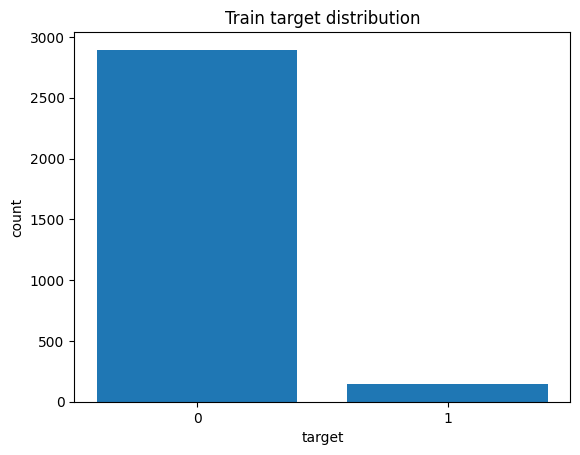

In [7]:
# 1) Class imbalance (train)
vc = train_log["target"].value_counts().sort_index()
plt.figure()
plt.bar(vc.index.astype(str), vc.values)
plt.title("Train target distribution")
plt.xlabel("target")
plt.ylabel("count")
plt.show()

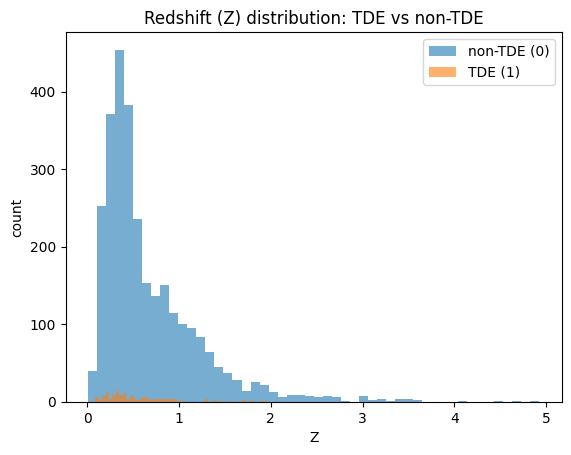

In [8]:
# 2) Z distribution by class
z0 = train_log.loc[train_log["target"]==0, "Z"].dropna().values
z1 = train_log.loc[train_log["target"]==1, "Z"].dropna().values
plt.figure()
plt.hist(z0, bins=50, alpha=0.6, label="non-TDE (0)")
plt.hist(z1, bins=50, alpha=0.6, label="TDE (1)")
plt.title("Redshift (Z) distribution: TDE vs non-TDE")
plt.xlabel("Z")
plt.ylabel("count")
plt.legend()
plt.show()

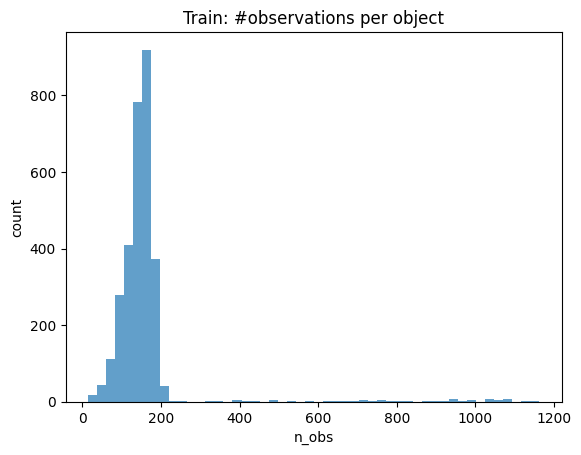

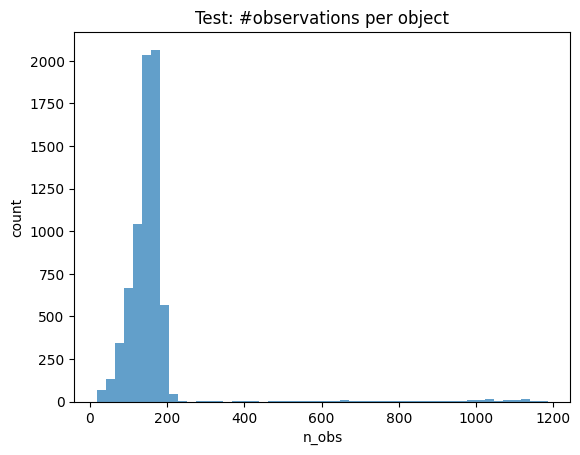

In [9]:
# 3) Observation count per object
plt.figure()
plt.hist(train_obj["n_obs"].values, bins=50, alpha=0.7)
plt.title("Train: #observations per object")
plt.xlabel("n_obs")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(test_obj["n_obs"].values, bins=50, alpha=0.7)
plt.title("Test: #observations per object")
plt.xlabel("n_obs")
plt.ylabel("count")
plt.show()

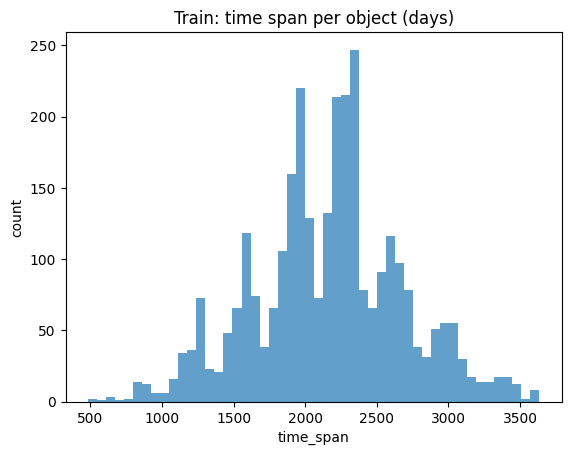

In [10]:
# 4) Time span per object
plt.figure()
plt.hist(train_obj["time_span"].values, bins=50, alpha=0.7)
plt.title("Train: time span per object (days)")
plt.xlabel("time_span")
plt.ylabel("count")
plt.show()

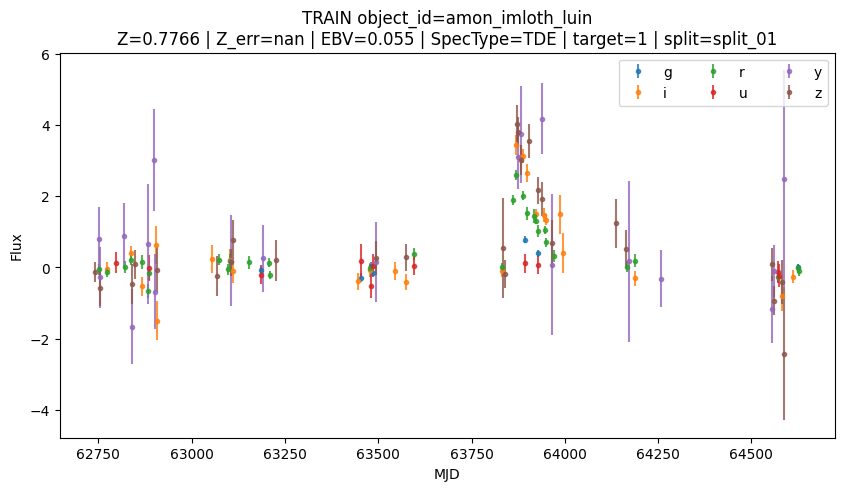

In [11]:
def plot_object(object_id: str, kind: str = "train"):
    lc = train_lc if kind == "train" else test_lc
    meta = train_log if kind == "train" else test_log

    df = lc.loc[lc["object_id"] == object_id].copy()
    df = df.sort_values(["band", "mjd"])

    # metadata line
    row = meta.loc[meta["object_id"] == object_id]
    meta_txt = ""
    if not row.empty:
        r = row.iloc[0]
        parts = []
        for col in ["Z", "Z_err", "EBV", "SpecType", "target", "split"]:
            if col in row.columns:
                parts.append(f"{col}={r.get(col)}")
        meta_txt = " | ".join(parts)

    plt.figure(figsize=(10, 5))
    for band in df["band"].cat.categories:
        d = df[df["band"] == band]
        if len(d) == 0:
            continue
        plt.errorbar(d["mjd"], d["flux"], yerr=d["flux_err"], fmt=".", alpha=0.8, label=str(band))

    plt.title(f"{kind.upper()} object_id={object_id}\n{meta_txt}")
    plt.xlabel("MJD")
    plt.ylabel("Flux")
    plt.legend(ncol=3)
    plt.show()

# Ví dụ
tde_ids = train_log.loc[train_log["target"]==1, "object_id"].tolist()
if tde_ids:
    plot_object(tde_ids[0], "train")

# Feature Engineering

In [12]:
def build_features(lc: pd.DataFrame) -> pd.DataFrame:
    g0 = lc.groupby("object_id").agg(
        n_obs=("flux", "size"),
        n_band=("band", "nunique"),
        mjd_min=("mjd", "min"),
        mjd_max=("mjd", "max"),
        flux_mean=("flux", "mean"),
        flux_std=("flux", "std"),
        flux_min=("flux", "min"),
        flux_max=("flux", "max"),
        flux_med=("flux", "median"),
        snr_mean=("snr", "mean"),
        snr_max=("snr", "max"),
        snr_med=("snr", "median"),
    )
    g0["time_span"] = g0["mjd_max"] - g0["mjd_min"]
    g0 = g0.drop(columns=["mjd_min","mjd_max"])

    gb = lc.groupby(["object_id", "band"]).agg(
        n_obs=("flux", "size"),
        flux_mean=("flux", "mean"),
        flux_std=("flux", "std"),
        flux_min=("flux", "min"),
        flux_max=("flux", "max"),
        flux_med=("flux", "median"),
        snr_mean=("snr", "mean"),
        snr_max=("snr", "max"),
        mjd_min=("mjd", "min"),
        mjd_max=("mjd", "max"),
    )
    gb["time_span"] = gb["mjd_max"] - gb["mjd_min"]
    gb = gb.drop(columns=["mjd_min","mjd_max"])

    gb_wide = gb.unstack("band")
    gb_wide.columns = [f"{feat}_band_{band}" for feat, band in gb_wide.columns]
    feats = g0.join(gb_wide, how="left").reset_index()
    return feats

train_feats = build_features(train_lc)
test_feats  = build_features(test_lc)
train_df = train_log.merge(train_feats, on="object_id", how="left")
test_df  = test_log.merge(test_feats, on="object_id", how="left")

for col in ["Z_err"]:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(0.0)

In [13]:
def _safe_interp(t, x, y):
    if len(x) < 2: 
        return np.nan
    if t < x[0] or t > x[-1]:
        return np.nan
    return float(np.interp(t, x, y))

def _crossing_time_left(t, y, t_peak, half):
    mask = t <= t_peak
    tt, yy = t[mask], y[mask]
    if len(tt) < 2:
        return np.nan
    idx = np.where(yy <= half)[0]
    if len(idx) == 0:
        return np.nan
    i0 = idx[-1]
    if i0 == len(tt)-1:
        return np.nan
    if yy[i0] == yy[i0+1]:
        return float(tt[i0])
    return float(tt[i0] + (half - yy[i0]) * (tt[i0+1] - tt[i0]) / (yy[i0+1] - yy[i0]))

def _crossing_time_right(t, y, t_peak, half):
    mask = t >= t_peak
    tt, yy = t[mask], y[mask]
    if len(tt) < 2:
        return np.nan
    idx = np.where(yy <= half)[0]
    if len(idx) == 0:
        return np.nan
    i0 = idx[0]
    if i0 == 0:
        return float(tt[0])
    if yy[i0-1] == yy[i0]:
        return float(tt[i0])
    return float(tt[i0-1] + (half - yy[i0-1]) * (tt[i0] - tt[i0-1]) / (yy[i0] - yy[i0-1]))

In [14]:
def extract_peak_features_one_object(df_obj, z_value=np.nan):
    out = {}
    global_tpeak = np.nan
    global_peak = -np.inf
    per_band_series = {}

    for b in BANDS:
        d = df_obj[df_obj["band"] == b]
        n = len(d)
        out[f"{b}_n"] = n
        if n < 3:
            continue

        t = d["mjd"].to_numpy(dtype=np.float64)
        f = d["flux"].to_numpy(dtype=np.float64)
        e = d["flux_err"].to_numpy(dtype=np.float64)

        order = np.argsort(t)
        t = t[order]; f = f[order]; e = e[order]

        kbase = max(1, int(0.2 * n))
        base = float(np.median(np.partition(f, kbase-1)[:kbase]))
        f0 = f - base

        ktop = max(3, int(0.05 * n))
        idx = np.argpartition(f0, -ktop)[-ktop:]
        peak = float(np.median(f0[idx]))
        tpeak = float(np.median(t[idx]))

        out[f"{b}_base"] = base
        out[f"{b}_peak"] = peak
        out[f"{b}_tpeak"] = tpeak
        out[f"{b}_snr_peak"] = float(np.nanmedian((f0[idx]) / (e[idx] + 1e-9)))

        half = 0.5 * peak
        t_left  = _crossing_time_left(t, f0, tpeak, half)
        t_right = _crossing_time_right(t, f0, tpeak, half)
        out[f"{b}_rise"]  = (tpeak - t_left) if np.isfinite(t_left) else np.nan
        out[f"{b}_decay"] = (t_right - tpeak) if np.isfinite(t_right) else np.nan
        out[f"{b}_width"] = (t_right - t_left) if (np.isfinite(t_left) and np.isfinite(t_right)) else np.nan
        out[f"{b}_asym"]  = (out[f"{b}_decay"] / (out[f"{b}_rise"] + 1e-9)) if np.isfinite(out[f"{b}_rise"]) else np.nan

        win = 50.0
        m = (t >= tpeak - win) & (t <= tpeak + win)
        if m.sum() >= 3:
            out[f"{b}_pwin_med"] = float(np.median(f0[m]))
            out[f"{b}_pwin_iqr"] = float(np.percentile(f0[m], 75) - np.percentile(f0[m], 25))
        else:
            out[f"{b}_pwin_med"] = np.nan
            out[f"{b}_pwin_iqr"] = np.nan

        per_band_series[b] = (t, f0)

        if peak > global_peak:
            global_peak = peak
            global_tpeak = tpeak

    out["global_tpeak"] = global_tpeak if np.isfinite(global_tpeak) else np.nan
    out["global_peak"]  = global_peak if np.isfinite(global_peak) else np.nan

    if np.isfinite(out["global_tpeak"]):
        tg = out["global_tpeak"]

        def val(b):
            if b not in per_band_series:
                return np.nan
            t, f0 = per_band_series[b]
            return _safe_interp(tg, t, f0)

        fg, fr, fi = val("g"), val("r"), val("i")
        out["color_g_r_at_peak"] = fg - fr if np.isfinite(fg) and np.isfinite(fr) else np.nan
        out["color_r_i_at_peak"] = fr - fi if np.isfinite(fr) and np.isfinite(fi) else np.nan

        if np.isfinite(out.get("g_tpeak", np.nan)) and np.isfinite(out.get("r_tpeak", np.nan)):
            out["lag_g_r"] = out["g_tpeak"] - out["r_tpeak"]
        else:
            out["lag_g_r"] = np.nan

        if np.isfinite(out.get("r_tpeak", np.nan)) and np.isfinite(out.get("i_tpeak", np.nan)):
            out["lag_r_i"] = out["r_tpeak"] - out["i_tpeak"]
        else:
            out["lag_r_i"] = np.nan

    if np.isfinite(z_value) and z_value > 0:
        scale = 1.0 / (1.0 + z_value)
        out["global_tscale"] = scale
        for b in ["g","r","i"]:
            for key in ["rise","decay","width"]:
                k = f"{b}_{key}"
                if k in out and np.isfinite(out[k]):
                    out[f"{k}_rest"] = out[k] * scale
                else:
                    out[f"{k}_rest"] = np.nan
    else:
        out["global_tscale"] = np.nan
        for b in ["g","r","i"]:
            for key in ["rise","decay","width"]:
                out[f"{b}_{key}_rest"] = np.nan

    return out

In [15]:
def build_peak_features(lc, meta):
    z_map = meta.set_index("object_id")["Z"].to_dict() if "Z" in meta.columns else {}
    feats = []
    for oid, df_obj in tqdm(lc.groupby("object_id"), total=lc["object_id"].nunique(), desc="Peak-features"):
        z = z_map.get(oid, np.nan)
        f = extract_peak_features_one_object(df_obj, z_value=z)
        f["object_id"] = oid
        feats.append(f)
    return pd.DataFrame(feats)

train_peak = build_peak_features(train_lc, train_log)
test_peak  = build_peak_features(test_lc, test_log)
train_df2 = train_df.merge(train_peak, on="object_id", how="left")
test_df2  = test_df.merge(test_peak,  on="object_id", how="left")

Peak-features:   0%|          | 0/3043 [00:00<?, ?it/s]

Peak-features:   0%|          | 0/7135 [00:00<?, ?it/s]

In [16]:
def normalize_lc(lc: pd.DataFrame) -> pd.DataFrame:
    lc = lc.copy()
    rename_map = {}
    if "Time (MJD)" in lc.columns: rename_map["Time (MJD)"] = "mjd"
    if "Flux" in lc.columns: rename_map["Flux"] = "flux"
    if "Flux_err" in lc.columns: rename_map["Flux_err"] = "flux_err"
    if "Filter" in lc.columns: rename_map["Filter"] = "band"
    if rename_map:
        lc = lc.rename(columns=rename_map)
    need = {"object_id","mjd","flux","flux_err","band"}
    miss = need - set(lc.columns)
    if miss:
        raise ValueError(f"Lightcurve missing columns: {miss}. Current cols: {lc.columns.tolist()}")
    lc["band"] = lc["band"].astype(str)
    return lc

In [17]:
def bazin(t, A, t0, tau_rise, tau_fall, C):
    return A * np.exp(-(t - t0) / tau_fall) / (1.0 + np.exp(-(t - t0) / tau_rise)) + C

def robust_baseline(y):
    n = len(y)
    k = max(1, int(0.2 * n))
    return float(np.median(np.partition(y, k-1)[:k]))

def robust_peak_time(t, y):
    n = len(y)
    k = max(3, int(0.05 * n))
    idx = np.argpartition(y, -k)[-k:]
    return float(np.median(t[idx])), float(np.median(y[idx]))

def fit_bazin_one_band(t, y, yerr):
    out = {
        "fit_success": 0,
        "A": np.nan, "t0_rel": np.nan, "tau_rise": np.nan, "tau_fall": np.nan, "C": np.nan,
        "chi2_red": np.nan, "rmse": np.nan, "n_fit": len(t)
    }
    n = len(t)
    if n < MIN_PTS_FIT:
        return out

    order = np.argsort(t)
    t = t[order].astype(np.float64)
    y = y[order].astype(np.float64)
    yerr = yerr[order].astype(np.float64)

    yerr = np.where((yerr <= 0) | (~np.isfinite(yerr)), np.nan, yerr)
    if np.all(~np.isfinite(yerr)):
        yerr = np.ones_like(y) * (np.nanstd(y) + 1e-3)
    else:
        mederr = np.nanmedian(yerr[np.isfinite(yerr)])
        yerr = np.where(np.isfinite(yerr), yerr, mederr)

    t_peak, y_peak = robust_peak_time(t, y)
    base = robust_baseline(y)
    A0 = max(1e-3, float(y_peak - base))

    m = (t >= t_peak - WIN_LEFT) & (t <= t_peak + WIN_RIGHT)
    if m.sum() >= MIN_PTS_FIT:
        t, y, yerr = t[m], y[m], yerr[m]

    t_rel = t - t_peak

    y_min, y_max = float(np.nanmin(y)), float(np.nanmax(y))
    pad = (y_max - y_min) + 1e-3
    bounds_lo = [0.0,      -WIN_LEFT,   1.0,    1.0,   y_min - pad]
    bounds_hi = [10*pad,    WIN_RIGHT,  300.0,  1200.0, y_max + pad]
    p0 = [A0, 0.0, 30.0, 200.0, base]

    try:
        popt, _ = curve_fit(
            bazin, t_rel, y,
            p0=p0,
            sigma=yerr,
            absolute_sigma=True,
            bounds=(bounds_lo, bounds_hi),
            maxfev=MAXFEV
        )
        A, t0_rel, tau_rise, tau_fall, C = popt
        yhat = bazin(t_rel, *popt)
        resid = (y - yhat)
        rmse = float(np.sqrt(np.mean(resid**2)))
        chi2 = float(np.sum(((resid) / (yerr + 1e-12))**2))
        dof = max(1, len(y) - 5)
        chi2_red = float(chi2 / dof)

        out.update({
            "fit_success": 1,
            "A": float(A),
            "t0_rel": float(t0_rel),
            "tau_rise": float(tau_rise),
            "tau_fall": float(tau_fall),
            "C": float(C),
            "chi2_red": chi2_red,
            "rmse": rmse,
            "n_fit": int(len(y))
        })
    except Exception:
        pass

    return out

In [18]:
def build_bazin_features(lc, df_meta, bands=BANDS_FIT, cache_path=None):
    lc = normalize_lc(lc)
    z_map = df_meta.set_index("object_id")["Z"].to_dict() if "Z" in df_meta.columns else {}

    feats = []
    for oid, g in tqdm(lc.groupby("object_id"), total=lc["object_id"].nunique(), desc="Bazin-fit"):
        row = {"object_id": oid}
        z = z_map.get(oid, np.nan)
        row["Z"] = z

        for b in bands:
            gb = g[g["band"] == b]
            if len(gb) < MIN_PTS_FIT:
                row.update({
                    f"bazin_{b}_fit": 0,
                    f"bazin_{b}_A": np.nan,
                    f"bazin_{b}_t0rel": np.nan,
                    f"bazin_{b}_trise": np.nan,
                    f"bazin_{b}_tfall": np.nan,
                    f"bazin_{b}_C": np.nan,
                    f"bazin_{b}_chi2": np.nan,
                    f"bazin_{b}_rmse": np.nan,
                    f"bazin_{b}_n": int(len(gb))
                })
                continue

            t = gb["mjd"].to_numpy()
            y = gb["flux"].to_numpy()
            e = gb["flux_err"].to_numpy()

            res = fit_bazin_one_band(t, y, e)
            row.update({
                f"bazin_{b}_fit": int(res["fit_success"]),
                f"bazin_{b}_A": res["A"],
                f"bazin_{b}_t0rel": res["t0_rel"],
                f"bazin_{b}_trise": res["tau_rise"],
                f"bazin_{b}_tfall": res["tau_fall"],
                f"bazin_{b}_C": res["C"],
                f"bazin_{b}_chi2": res["chi2_red"],
                f"bazin_{b}_rmse": res["rmse"],
                f"bazin_{b}_n": int(res["n_fit"])
            })

            row[f"bazin_{b}_logA"] = np.log1p(res["A"]) if np.isfinite(res["A"]) and res["A"] > 0 else np.nan
            row[f"bazin_{b}_logtrise"] = np.log1p(res["tau_rise"]) if np.isfinite(res["tau_rise"]) and res["tau_rise"] > 0 else np.nan
            row[f"bazin_{b}_logtfall"] = np.log1p(res["tau_fall"]) if np.isfinite(res["tau_fall"]) and res["tau_fall"] > 0 else np.nan
            row[f"bazin_{b}_ratio_fall_rise"] = (res["tau_fall"] / (res["tau_rise"] + 1e-9)) if np.isfinite(res["tau_fall"]) and np.isfinite(res["tau_rise"]) else np.nan

            if np.isfinite(z) and z > 0 and np.isfinite(res["tau_rise"]) and np.isfinite(res["tau_fall"]):
                scale = 1.0 / (1.0 + z)
                row[f"bazin_{b}_trise_rest"] = res["tau_rise"] * scale
                row[f"bazin_{b}_tfall_rest"] = res["tau_fall"] * scale
            else:
                row[f"bazin_{b}_trise_rest"] = np.nan
                row[f"bazin_{b}_tfall_rest"] = np.nan

        feats.append(row)

    out = pd.DataFrame(feats)
    if cache_path:
        out.to_parquet(cache_path, index=False)
    return out

In [19]:
def add_physics_features(lc_df, meta_df):
    lc = lc_df.merge(meta_df[['object_id', 'EBV', 'Z']], on='object_id', how='left')
    lc['A_lambda'] = lc['band'].astype(str).map(EXTINCTION_COEFFS).astype(float) * lc['EBV'].astype(float)
    lc['flux_corr_factor'] = 10 ** (0.4 * lc['A_lambda'])
    lc['flux_corr'] = lc['flux'] * lc['flux_corr_factor']

    peak_flux = lc.groupby(['object_id', 'band'])['flux_corr'].max().unstack('band')
    peak_flux.columns = [f'peak_flux_corr_{c}' for c in peak_flux.columns]

    features = pd.DataFrame(index=peak_flux.index)

    for b in ['u', 'g', 'r', 'i', 'z', 'y']:
        col = f'peak_flux_corr_{b}'
        if col in peak_flux.columns:
            features[col] = peak_flux[col]
            features[f'log_peak_{b}'] = np.log1p(np.maximum(peak_flux[col], 0))

    if 'log_peak_g' in features and 'log_peak_r' in features:
        features['color_g_r'] = features['log_peak_g'] - features['log_peak_r']
    if 'log_peak_u' in features and 'log_peak_g' in features:
        features['color_u_g'] = features['log_peak_u'] - features['log_peak_g']

    z_info = meta_df.set_index('object_id')[['Z']]
    features = features.join(z_info)

    features['dist_mod_proxy'] = 2.0 * np.log10(features['Z'] + 0.0001)
    for b in ['g', 'r']:
        if f'log_peak_{b}' in features:
            features[f'abs_mag_proxy_{b}'] = features[f'log_peak_{b}'] - features['dist_mod_proxy']

    return features.reset_index()

In [20]:
def best_f1_threshold(y_true, y_prob):
    th = np.linspace(0.01, 0.99, 991)
    f1s = np.array([f1_score(y_true, y_prob >= t) for t in th])
    j = int(f1s.argmax())
    return float(th[j]), float(f1s[j])

def trimmed_mean(values):
    s = sorted(values)
    if len(s) <= 2:
        return float(np.mean(s))
    return float(np.mean(s[1:-1]))

def make_balanced_group_folds(df, group_col="split", y_col="target", n_splits=5, seed=SEED):
    g = df.groupby(group_col)[y_col].agg(["count","sum"]).reset_index()
    pos = g[g["sum"] > 0].sample(frac=1, random_state=seed).sort_values("sum", ascending=False)
    zero = g[g["sum"] == 0].sample(frac=1, random_state=seed)

    fold_groups = [[] for _ in range(n_splits)]
    fold_pos = np.zeros(n_splits, dtype=int)
    fold_cnt = np.zeros(n_splits, dtype=int)

    for _, r in pos.iterrows():
        k = int(np.argmin(fold_pos))
        fold_groups[k].append(r[group_col])
        fold_pos[k] += int(r["sum"])
        fold_cnt[k] += int(r["count"])

    for _, r in zero.iterrows():
        k = int(np.argmin(fold_cnt))
        fold_groups[k].append(r[group_col])
        fold_cnt[k] += int(r["count"])

    folds, rep = [], []
    for k in range(n_splits):
        val_mask = df[group_col].isin(fold_groups[k]).values
        va = np.where(val_mask)[0]
        tr = np.where(~val_mask)[0]
        folds.append((tr, va))
        rep.append([k, len(va), int(df.iloc[va][y_col].sum())])

    rep = pd.DataFrame(rep, columns=["fold","n_val","pos_val"])
    print("\n=== Balanced folds report ===")
    print(rep)
    print("Any fold with 0 pos?", bool((rep["pos_val"]==0).any()))
    return folds

In [21]:
print("=== Building/Loading Bazin features ===")
if os.path.exists(CACHE_TRAIN):
    train_bazin = pd.read_parquet(CACHE_TRAIN)
    print("Loaded", CACHE_TRAIN, train_bazin.shape)
else:
    train_bazin = build_bazin_features(train_lc, train_df2, cache_path=CACHE_TRAIN)
    print("Saved", CACHE_TRAIN, train_bazin.shape)

if os.path.exists(CACHE_TEST):
    test_bazin = pd.read_parquet(CACHE_TEST)
    print("Loaded", CACHE_TEST, test_bazin.shape)
else:
    test_bazin = build_bazin_features(test_lc, test_df2, cache_path=CACHE_TEST)
    print("Saved", CACHE_TEST, test_bazin.shape)

=== Building/Loading Bazin features ===


Bazin-fit:   0%|          | 0/3043 [00:00<?, ?it/s]

Saved train_bazin.parquet (3043, 47)


Bazin-fit:   0%|          | 0/7135 [00:00<?, ?it/s]

Saved test_bazin.parquet (7135, 47)


In [22]:
train_df = train_df2.merge(train_bazin.drop(columns=["Z"], errors="ignore"), on="object_id", how="left")
test_df  = test_df2.merge(test_bazin.drop(columns=["Z"], errors="ignore"),  on="object_id", how="left")

y = train_df["target"].astype(int).values

drop_cols = {"object_id","target","split","SpecType","English Translation"}
feature_cols = [c for c in train_df.columns if c not in drop_cols]

In [23]:
bad = [c for c in feature_cols if ("_auc_" in c) or ("_snr5_win" in c) or ("_auc_win_ratio" in c)]
if bad:
    feature_cols = [c for c in feature_cols if c not in set(bad)]
    print(f"Excluded {len(bad)} AUC-related features (safety).")

folds = make_balanced_group_folds(train_df, "split", "target", n_splits=5, seed=SEED)
if any(train_df.iloc[va]["target"].sum() == 0 for _, va in folds):
    print("Some fold has 0 positives with 5 folds -> switching to 4 folds")
    folds = make_balanced_group_folds(train_df, "split", "target", n_splits=4, seed=SEED)


=== Balanced folds report ===
   fold  n_val  pos_val
0     0    602       30
1     1    599       29
2     2    609       29
3     3    606       30
4     4    627       30
Any fold with 0 pos? False


# Modeling

## LightGBM

In [24]:
# ---- LGB (same params) ----
X_train_lgb = train_df[feature_cols].apply(pd.to_numeric, errors="coerce").replace([np.inf,-np.inf], np.nan).fillna(-999.0)
X_test_lgb  = test_df[feature_cols].apply(pd.to_numeric, errors="coerce").replace([np.inf,-np.inf], np.nan).fillna(-999.0)

pos = y.sum()
neg = len(y) - pos
scale_pos_weight = float(neg / max(1, pos))
print("\nscale_pos_weight:", scale_pos_weight)

params_lgb = dict(
    objective="binary",
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    min_data_in_leaf=50,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    lambda_l1=0.2,
    lambda_l2=0.2,
    scale_pos_weight=scale_pos_weight,
    verbose=-1,
)

oof_lgb = np.zeros(len(X_train_lgb), dtype=np.float32)
pred_lgb = np.zeros(len(X_test_lgb), dtype=np.float32)
best_iters = []

for fold, (tr, va) in enumerate(folds, 1):
    dtr = lgb.Dataset(X_train_lgb.iloc[tr], label=y[tr])
    dva = lgb.Dataset(X_train_lgb.iloc[va], label=y[va])
    model = lgb.train(
        params_lgb,
        dtr,
        num_boost_round=6000,
        valid_sets=[dva],
        callbacks=[lgb.early_stopping(250, verbose=False)]
    )
    best_iters.append(model.best_iteration)
    oof_lgb[va] = model.predict(X_train_lgb.iloc[va], num_iteration=model.best_iteration)
    pred_lgb += model.predict(X_test_lgb, num_iteration=model.best_iteration) / len(folds)

t_lgb, f1_lgb = best_f1_threshold(y, oof_lgb)
print("\n[LGB] OOF best_thr:", t_lgb, "OOF F1:", f1_lgb, "best_iter_mean:", int(np.mean(best_iters)))


scale_pos_weight: 19.56081081081081

[LGB] OOF best_thr: 0.23074747474747476 OOF F1: 0.4606741573033708 best_iter_mean: 173


## Catboost

In [25]:
# ---- CAT (same params) ----
X_train_cat = train_df[feature_cols].replace([np.inf,-np.inf], np.nan)
X_test_cat  = test_df[feature_cols].replace([np.inf,-np.inf], np.nan)

oof_cat = np.zeros(len(X_train_cat), dtype=np.float32)
pred_cat = np.zeros(len(X_test_cat), dtype=np.float32)

params_cat = dict(
    loss_function="Logloss",
    eval_metric="AUC",
    learning_rate=0.03,
    depth=7,
    iterations=25000,
    l2_leaf_reg=8.0,
    random_seed=SEED,
    verbose=False,
    auto_class_weights="Balanced",
    subsample=0.85,
    rsm=0.85
)

for fold, (tr, va) in enumerate(folds, 1):
    model = CatBoostClassifier(**params_cat)
    model.fit(
        X_train_cat.iloc[tr], y[tr],
        eval_set=(X_train_cat.iloc[va], y[va]),
        use_best_model=True,
        early_stopping_rounds=700
    )
    oof_cat[va] = model.predict_proba(X_train_cat.iloc[va])[:, 1]
    pred_cat += model.predict_proba(X_test_cat)[:, 1] / len(folds)

t_cat, f1_cat = best_f1_threshold(y, oof_cat)
print("[CAT] OOF best_thr:", t_cat, "OOF F1:", f1_cat)

[CAT] OOF best_thr: 0.4732727272727273 OOF F1: 0.39009287925696595


In [26]:
print("Extracting Physics Features...")
train_phys = add_physics_features(train_lc, train_log)
test_phys  = add_physics_features(test_lc, test_log)

Extracting Physics Features...


In [27]:
cols_to_use = [c for c in train_phys.columns if c not in train_df.columns or c == 'object_id']
train_df_final = train_df.merge(train_phys[cols_to_use], on='object_id', how='left')
test_df_final  = test_df.merge(test_phys[cols_to_use],  on='object_id', how='left')

## XGBoost

In [28]:
features = [c for c in train_df_final.columns
            if c not in ['object_id', 'target', 'split', 'SpecType', 'English Translation', 'Z_err', 'Z']]

X = train_df_final[features].replace([np.inf, -np.inf], np.nan)
y2 = train_df_final['target'].astype(int).values
X_test_submit = test_df_final[features].replace([np.inf, -np.inf], np.nan)

scale_pos_weight_xgb = (len(y2) - y2.sum()) / max(1, y2.sum())
print("scale_pos_weight (XGB):", float(scale_pos_weight_xgb))

xgb_train_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": float(scale_pos_weight_xgb),
    "tree_method": "hist",
    "seed": 42,
    "nthread": -1,
}

NUM_BOOST_ROUND = 2000 
EARLY_STOP_ROUNDS = 100

oof_xgb = np.zeros(len(X), dtype=np.float32)
pred_xgb = np.zeros(len(X_test_submit), dtype=np.float32)

for fold_idx, (train_idx, val_idx) in enumerate(folds, 1):
    X_tr, y_tr = X.iloc[train_idx], y2[train_idx]
    X_val, y_val = X.iloc[val_idx], y2[val_idx]

    dtr = xgb.DMatrix(X_tr, label=y_tr, missing=np.nan)
    dva = xgb.DMatrix(X_val, label=y_val, missing=np.nan)
    dte = xgb.DMatrix(X_test_submit, missing=np.nan)

    bst = xgb.train(
        params=xgb_train_params,
        dtrain=dtr,
        num_boost_round=NUM_BOOST_ROUND,
        evals=[(dva, "val")],
        verbose_eval=False,
        callbacks=[xgb.callback.EarlyStopping(rounds=EARLY_STOP_ROUNDS, save_best=True)]
    )

    # predict using best_iteration if available
    if hasattr(bst, "best_iteration") and bst.best_iteration is not None:
        it_end = bst.best_iteration + 1
        val_pred = bst.predict(dva, iteration_range=(0, it_end))
        test_pred = bst.predict(dte, iteration_range=(0, it_end))
    else:
        val_pred = bst.predict(dva)
        test_pred = bst.predict(dte)

    oof_xgb[val_idx] = val_pred.astype(np.float32)
    pred_xgb += test_pred.astype(np.float32) / len(folds)

    thresholds = np.linspace(0.01, 0.99, 991)
    f1s = [f1_score(y_val, val_pred >= t) for t in thresholds]
    print(f"Fold {fold_idx} XGB F1: {max(f1s):.4f}")

scale_pos_weight (XGB): 19.56081081081081
Fold 1 XGB F1: 0.4783
Fold 2 XGB F1: 0.4706
Fold 3 XGB F1: 0.3838
Fold 4 XGB F1: 0.5882
Fold 5 XGB F1: 0.4407


In [29]:
thresholds = np.linspace(0.01, 0.99, 991)

def find_best_threshold(oof_pred, y_true):
    f1s = [f1_score(y_true, oof_pred >= t) for t in thresholds]
    idx = int(np.argmax(f1s))
    return thresholds[idx], f1s[idx]

In [30]:
single_models = {
    "xgb": (oof_xgb, pred_xgb),
    "lgb": (oof_lgb, pred_lgb),
    "cat": (oof_cat, pred_cat),
}

for name, (oof, pred) in single_models.items():
    thr, f1 = find_best_threshold(oof, y2)
    print(f"[SINGLE] {name.upper()} | best_thr={thr:.4f} | f1={f1:.5f}")

    sub = pd.DataFrame({
        "object_id": test_df_final["object_id"],
        "prediction": pred
    })

    sub_label = sub.copy()
    sub_label["prediction"] = (pred >= thr).astype(int)

    sub_label.to_csv(f"submission_{name}.csv", index=False)

[SINGLE] XGB | best_thr=0.2575 | f1=0.44838
[SINGLE] LGB | best_thr=0.2307 | f1=0.46067
[SINGLE] CAT | best_thr=0.4733 | f1=0.39009


## Ensemble 2 models

In [31]:
weights = np.arange(0.0, 1.01, 0.01)

pair_models = {
    "xgb_lgb": (oof_xgb, oof_lgb, pred_xgb, pred_lgb),
    "xgb_cat": (oof_xgb, oof_cat, pred_xgb, pred_cat),
    "lgb_cat": (oof_lgb, oof_cat, pred_lgb, pred_cat),
}

for name, (oof_a, oof_b, pred_a, pred_b) in pair_models.items():
    best_f1 = -1
    best_cfg = None

    for w in weights:
        oof_ens = w * oof_a + (1 - w) * oof_b
        thr, f1 = find_best_threshold(oof_ens, y2)

        if f1 > best_f1:
            best_f1 = f1
            best_cfg = (w, thr)

    w, thr = best_cfg
    print(f"[PAIR] {name.upper()} | w={w:.2f}/{1-w:.2f} | thr={thr:.4f} | f1={best_f1:.5f}")

    final_prob = w * pred_a + (1 - w) * pred_b

    sub = pd.DataFrame({
        "object_id": test_df_final["object_id"],
        "prediction": final_prob
    })

    sub_label = sub.copy()
    sub_label["prediction"] = (final_prob >= thr).astype(int)

    sub_label.to_csv(f"submission_{name}.csv", index=False)

[PAIR] XGB_LGB | w=0.30/0.70 | thr=0.2258 | f1=0.46761
[PAIR] XGB_CAT | w=0.54/0.46 | thr=0.3139 | f1=0.46688
[PAIR] LGB_CAT | w=0.84/0.16 | thr=0.2129 | f1=0.46438


## Ensemble 3 models

In [32]:
print("Searching best 3-model ensemble...")

weights = np.arange(0.0, 1.01, 0.05)
best_f1 = -1
best_cfg = None

for w_xgb in weights:
    for w_lgb in weights:
        w_cat = 1.0 - w_xgb - w_lgb
        if w_cat < 0:
            continue

        oof_ens = (
            w_xgb * oof_xgb +
            w_lgb * oof_lgb +
            w_cat * oof_cat
        )

        thr, f1 = find_best_threshold(oof_ens, y2)

        if f1 > best_f1:
            best_f1 = f1
            best_cfg = (w_xgb, w_lgb, w_cat, thr)

w_xgb, w_lgb, w_cat, thr = best_cfg
print(f"[TRIPLE] XGB/LGB/CAT = {w_xgb:.2f}/{w_lgb:.2f}/{w_cat:.2f} | thr={thr:.4f} | f1={best_f1:.5f}")

final_prob = (
    w_xgb * pred_xgb +
    w_lgb * pred_lgb +
    w_cat * pred_cat
)

sub = pd.DataFrame({
    "object_id": test_df_final["object_id"],
    "prediction": final_prob
})

sub_label = sub.copy()
sub_label["prediction"] = (final_prob >= thr).astype(int)

sub_label.to_csv("submission_xgb_lgb_cat.csv", index=False)

Searching best 3-model ensemble...
[TRIPLE] XGB/LGB/CAT = 0.30/0.40/0.30 | thr=0.2555 | f1=0.47059
